In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
src_path = os.path.join('..', 'src')
if not src_path in sys.path:
    sys.path.insert(0, src_path)

from Company_Lister import Company_Lister


**Our analysis is limited to companies in the S&P 500**

In [8]:
snp = set(Company_Lister().get_snp())

In [10]:
og_q_path = os.path.join('..', 'data_files', 'quarterly_orig.csv')
og_qdf = pd.read_csv(og_q_path)
og_qdf = og_qdf.loc[og_qdf['tic'].isin(snp)]

/var/folders/5w/9htyqd7s7fvcqcn47w7nfyqc0000gn/T/ipykernel_30892/1018592985.py:2: DtypeWarning: Columns (10,17,26,30,650,657,668,669,679) have mixed types. Specify dtype option on import or set low_memory=False.
  og_qdf = pd.read_csv(og_q_path)


/var/folders/5w/9htyqd7s7fvcqcn47w7nfyqc0000gn/T/ipykernel_30892/4267500095.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


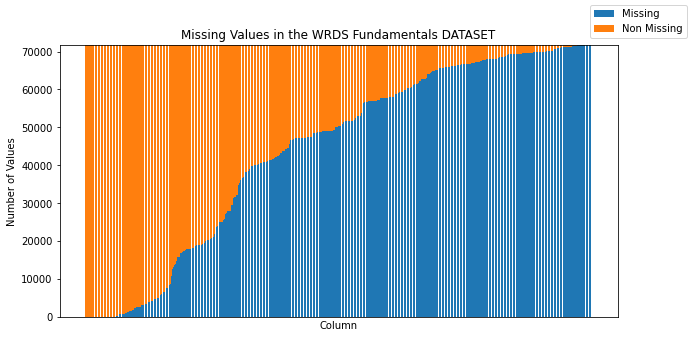

In [11]:
missing = og_qdf.apply(lambda col: pd.isna(col).sum()).sort_values()
non_missing = len(og_qdf) - missing
fig, ax = plt.subplots()
ax.bar(missing.index.values, missing.values, label='Missing')
ax.bar(non_missing.index.values, non_missing.values, bottom=missing, label='Non Missing')
ax.set_title('Missing Values in the WRDS Fundamentals DATASET')
ax.set_xlabel('Column')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel('Number of Values')
fig.set_size_inches(10, 5)
fig.legend()

In [12]:
missing['fqtr'] / len(og_qdf)
og_qdf['fyearq'].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 1969])

In [13]:
good_cols = missing[missing < 0.01].index
og_qdf.iloc[3][good_cols]

gvkey                                                    1045
fic                                                       USA
rp                                                          Q
busdesc     American Airlines Group Inc., through its subs...
sic                                                      4512
updq                                                        3
city                                               Fort Worth
conml                             American Airlines Group Inc
fyrc                                                       12
ggroup                                                   2030
gind                                                   203020
gsector                                                    20
gsubind                                              20302010
idbflag                                                     B
loc                                                       USA
naics                                                  481111
costat  

In [14]:
og_qdf['spcindcd'].unique()
og_qdf['spcseccd'].unique()

array([600., 700., 905., 940., 970., 925., 935., 800., 974., 976., 978.,
        nan])

**We will require that a column has at least 90% of its data to proceed to the next step of cleaning**
- This is a reasonable requirement because most of the columns are highly correlated with some other column in the data set that is more frequently reported
- In the end, we want the fundamental metrics that are used by a broad range of comapanies. 

## The columns we will investigate futher are as follows:
- tic: company ticker
- datadate: date of the data
- choq: common shares outstanding (we can use this to normalize)
- spcindcd: s&p industry classification code.
- spcseccd: s&p sector classification code.
- revtq: total revenue in millions.
- epspxq: earnings per share excluding extraordinary items in dollars.
- epspiq: earnings per share including extraordinary items in dollars.
- cheq: cash and short term investments in millions.
- dlttq: long term debt in millions.
- ltq: total liabilities in millions.
- oiadpq: operating income after depreciation
- dvpspq: common dividens paid per share by pay date

In [15]:
interest_cols = ['tic', 'fqtr', 'fyearq', 'datadate', 'cshoq', 'spcindcd', 'spcseccd', 'revtq', 'epspxq', 'epspiq', 'cheq', 'dlttq', 'ltq', 'oiadpq', 'dvpspq']
filtered_qdf = og_qdf[interest_cols].copy()
filtered_qdf

,tic,fqtr,fyearq,datadate,cshoq,spcindcd,spcseccd,revtq,epspxq,epspiq,cheq,dlttq,ltq,oiadpq,dvpspq
0,AAL,1.0,1970,03/31/1970,NaN,605.0,600.0,265.936,-0.22,-0.22,NaN,NaN,NaN,NaN,NaN
1,AAL,2.0,1970,06/30/1970,NaN,605.0,600.0,287.742,0.13,0.13,NaN,NaN,NaN,NaN,NaN
2,AAL,3.0,1970,09/30/1970,NaN,605.0,600.0,310.243,0.14,0.14,NaN,NaN,NaN,NaN,NaN
3,AAL,4.0,1970,12/31/1970,20.281,605.0,600.0,268.858,-1.36,-1.36,NaN,713.07,NaN,-7.865,NaN
4,AAL,1.0,1971,03/31/1971,NaN,605.0,600.0,263.294,-1.19,-1.19,NaN,NaN,NaN,NaN,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71936,ALLE,4.0,2020,12/31/2020,91.213,NaN,NaN,727.300,1.02,1.02,480.4,1495.70,2236.8,163.200,0.32
71937,ALLE,1.0,2021,03/31/2021,90.049,NaN,NaN,694.300,1.19,1.19,394.3,1495.20,2216.9,131.300,0.36
71938,ALLE,2.0,2021,06/30/2021,89.765,NaN,NaN,746.900,1.32,1.32,460.2,1491.80,2272.7,145.700,0.36
71939,ALLE,3.0,2021,09/30/2021,89.696,NaN,NaN,717.000,1.60,1.60,503.9,1256.40,2249.1,142.200,0.36


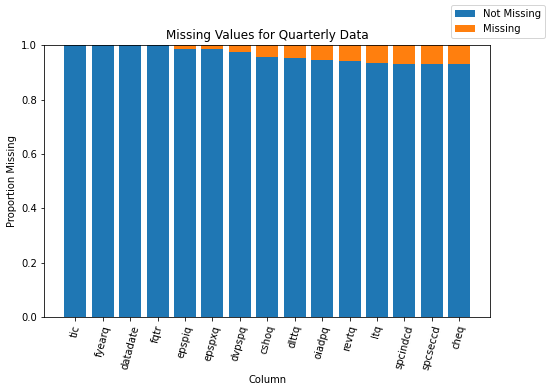

In [16]:
missing = filtered_qdf.apply(lambda col: pd.isna(col).sum()) / len(filtered_qdf)
missing = missing.sort_values()
not_missing = 1 - missing
fig, ax = plt.subplots()
ax.bar(not_missing.index, not_missing.values, label='Not Missing')
ax.bar(missing.index, missing.values, bottom=not_missing, label='Missing')
ax.set_xticks(np.arange(len(missing)))
ax.set_xticklabels(missing.index, rotation=75)
ax.set_title('Missing Values for Quarterly Data')
ax.set_xlabel('Column')
ax.set_ylabel('Proportion Missing')
fig.legend()
fig.set_size_inches(8, 5)

## Lets examine the distributions of the variables

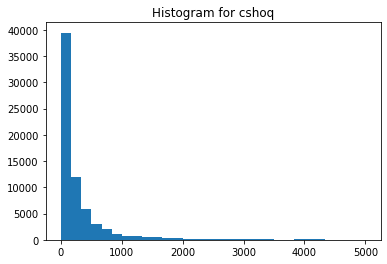

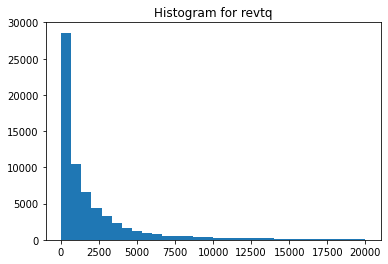

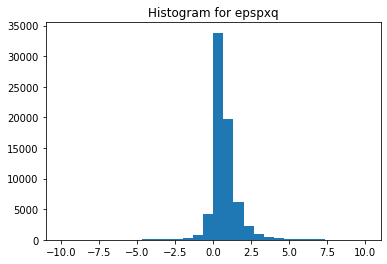

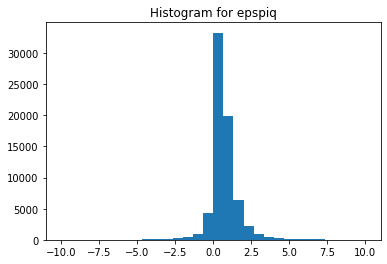

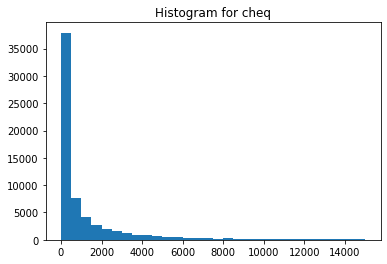

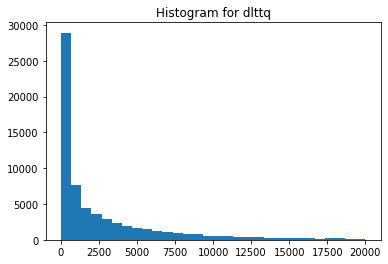

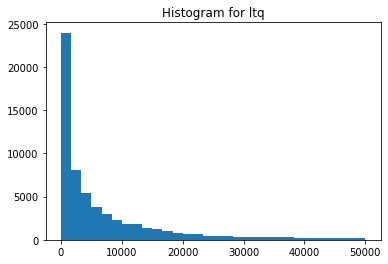

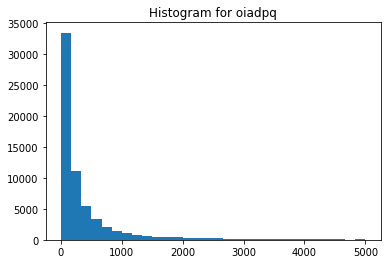

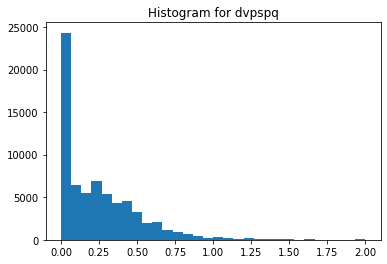

In [18]:
no_plot = set(['tic', 'fqtr', 'fyearq', 'datadate', 'spcindcd', 'spcseccd'])
args = {
    'revtq': {
        'range': [0, 20000],
    },
    'epspxq': {
        'range': [-10, 10],
    },
    'epspiq': {
        'range': [-10, 10],
    },
    'cheq': {
        'range': [0, 15000],
    },
    'dlttq': {
        'range': [0, 20000],
    },
    'ltq': {
        'range': [0, 50000],
    },
    'oiadpq': {
        'range': [0, 5000],
    },
    'dvpspq': {
        'range': [0, 2],
    },
    'cshoq': {
        'range': [0, 5000],
    },
}

for col in filtered_qdf.columns:
    if col in no_plot:
        continue
    fig, ax = plt.subplots()
    ax.hist(filtered_qdf[col], bins=30, **args[col])
    ax.set_title('Histogram for ' + col)
    

## Takeaways:
- We should normalize cheq, dlttq, ltq, and oiadpq by the number of shares

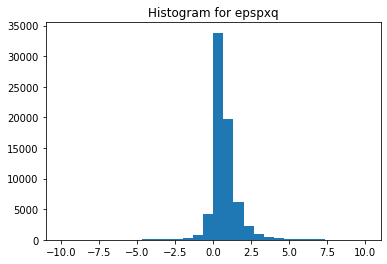

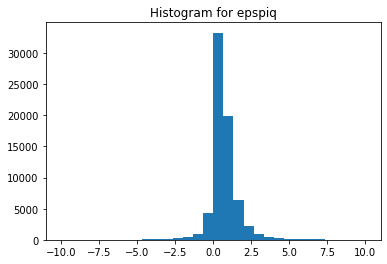

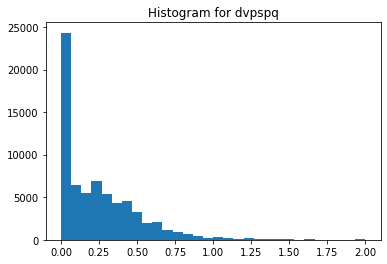

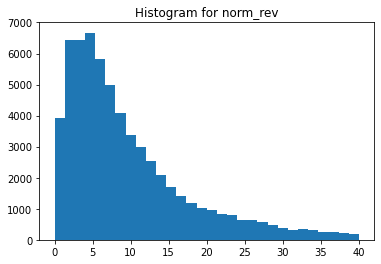

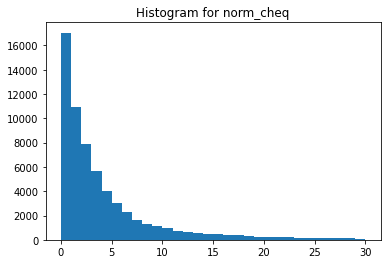

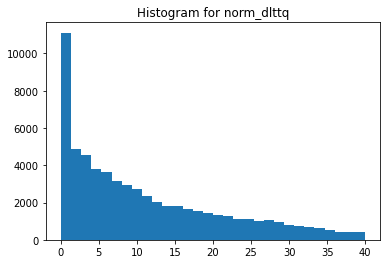

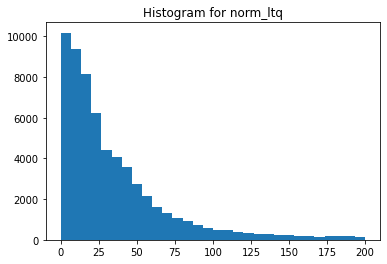

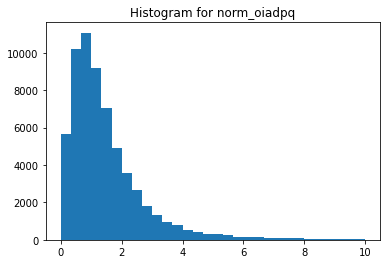

In [20]:
norm_qdf = filtered_qdf.copy()
no_plot = ['tic', 'fqtr', 'fyearq', 'datadate', 'spcindcd', 'spcseccd']

norm_qdf['norm_rev'] = norm_qdf['revtq'] / norm_qdf['cshoq']
norm_qdf['norm_cheq'] = norm_qdf['cheq'] / norm_qdf['cshoq']
norm_qdf['norm_dlttq'] = norm_qdf['dlttq'] / norm_qdf['cshoq']
norm_qdf['norm_ltq'] = norm_qdf['ltq'] / norm_qdf['cshoq']
norm_qdf['norm_oiadpq'] = norm_qdf['oiadpq'] / norm_qdf['cshoq']

norm_qdf = norm_qdf.drop(columns=['revtq', 'cheq', 'dlttq', 'ltq', 'oiadpq', 'cshoq'])

args = {
    'norm_rev': {
        'range': [0, 40],
    },
    'epspxq': {
        'range': [-10, 10],
    },
    'epspiq': {
        'range': [-10, 10],
    },
    'norm_cheq': {
        'range': [0, 30],
    },
    'norm_dlttq': {
        'range': [0, 40],
    },
    'norm_ltq': {
        'range': [0, 200],
    },
    'norm_oiadpq': {
        'range': [0, 10],
    },
    'dvpspq': {
        'range': [0, 2],
    },
    'cshoq': {
        'range': [0, 5000],
    },
}

for col in norm_qdf.columns:
    if col in no_plot:
        continue
    fig, ax = plt.subplots()
    ax.hist(norm_qdf[col], bins=30, **args[col])
    ax.set_title('Histogram for ' + col)
    

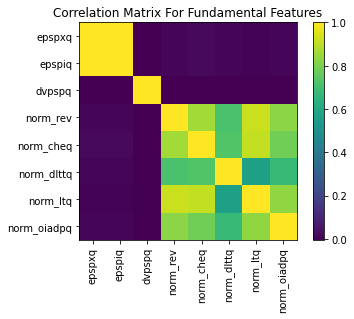

In [21]:
feature_cols = list(norm_qdf.columns)
[feature_cols.remove(np) for np in no_plot]
corr_df = norm_qdf[feature_cols].corr()
fig, ax = plt.subplots()
cbar = ax.imshow(corr_df)
ax.set_xticks(np.arange(len(corr_df)))
ax.set_xticklabels(corr_df.index.values, rotation=90)
ax.set_yticks(np.arange(len(corr_df)))
ax.set_yticklabels(corr_df.index.values)
ax.set_title('Correlation Matrix For Fundamental Features')
fig.colorbar(cbar)

In [22]:
norm_qdf.columns

Index(['tic', 'fqtr', 'fyearq', 'datadate', 'spcindcd', 'spcseccd', 'epspxq',
       'epspiq', 'dvpspq', 'norm_rev', 'norm_cheq', 'norm_dlttq', 'norm_ltq',
       'norm_oiadpq'],
      dtype='object')

In [23]:
norm_qdf['datadate']

0        03/31/1970
1        06/30/1970
2        09/30/1970
3        12/31/1970
4        03/31/1971
            ...    
71936    12/31/2020
71937    03/31/2021
71938    06/30/2021
71939    09/30/2021
71940    12/31/2021
Name: datadate, Length: 71741, dtype: object

## Write the portion of the quarterly data that we will use to a new dataframe

In [24]:
filtered_qdf.to_csv(os.path.join('..', 'data_files', 'quarterly_filtered.csv'), index=False)